# Setup

In [3]:
import os, sys
import pandas as pd
import numpy as np
import math
import random
from typing import DefaultDict
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, roc_curve, auc
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import cross_val_predict, GridSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from functools import partial

import joblib
import warnings
from sklearn.exceptions import ConvergenceWarning

from IPython.display import display

In [4]:
ROOT = "/content"
data_file = os.path.join(ROOT, "data/Task3and4_Loan_Data.csv")
if not os.path.exists(data_file):
    print("File not found")
    sys.exit(1)

df = pd.read_csv(data_file)

# Exploratory Data Analysis

In [5]:
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


In [6]:
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [7]:
df.sort_values(by='loan_amt_outstanding', ascending=False).head(5)

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
3639,8927585,1,10750.67781,16953.237650,148412.1805,6,657,0
890,1773897,2,10467.73206,20825.284860,130912.3875,5,671,0
1997,6597386,5,10210.74669,33515.971170,107870.3896,2,649,1
6526,4110450,0,10190.83866,3717.620173,117370.6607,4,675,0
7658,1605704,1,10006.51554,16251.289160,132504.2350,5,670,0


In [8]:
# sheet = sheets.InteractiveSheet(df=df)

In [9]:
# explore correlation of each variable with defaulting
# heatmap of correlation matrix, exclude customer_id as irrelevant
df.drop(columns=['customer_id']).corr().style.background_gradient(cmap=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True))

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
credit_lines_outstanding,1.000000,0.080249,0.852210,0.022272,-0.087900,-0.258177,0.862815
loan_amt_outstanding,0.080249,1.000000,0.397403,0.835815,-0.158416,-0.031373,0.098978
total_debt_outstanding,0.852210,0.397403,1.000000,0.394397,-0.174353,-0.232246,0.758868
income,0.022272,0.835815,0.394397,1.000000,0.001814,-0.010528,0.016309
years_employed,-0.087900,-0.158416,-0.174353,0.001814,1.000000,0.255873,-0.284506
fico_score,-0.258177,-0.031373,-0.232246,-0.010528,0.255873,1.000000,-0.324515
default,0.862815,0.098978,0.758868,0.016309,-0.284506,-0.324515,1.000000


#### We can't state that high absolute values in the default column mean that one of those six features cause defaults. But there is strong correlation when the absolute value is close to 1.

#### - **Strong Positive Correlation:** The variables `credit_lines_outstanding` and `total_debt_outstanding` have a strong positive correlation with `default`.
#### - **Inverse Correlation:** The variables `years_employed` and `fico_score` suggest high values result in lower `default` rates.
#### - **Weak Relation:** Variables like `income` and `loan_amt_outstanding` seem to have low influence on loan `default`.

#### These observations can guide our feature selection.

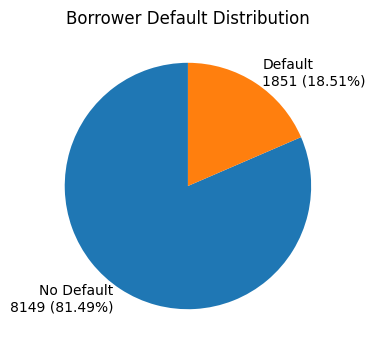

In [10]:
# # pie chart of borrower default distribution
no_defaults =  df[df['default'] == 0]
yes_defaults = df[df['default'] == 1]

no_default_ct, yes_default_ct, total_borrowers = len(no_defaults), len(yes_defaults), len(df)

# # Create labels with both percentage and count
labels = [f'No Default\n{no_default_ct} ({no_default_ct/total_borrowers:.2%})',
          f'Default\n{yes_default_ct} ({yes_default_ct/total_borrowers:.2%})']

plt.figure(figsize=(6, 4))
plt.pie(df['default'].value_counts(), labels=labels, autopct='', startangle=90)
plt.title('Borrower Default Distribution')
plt.show()

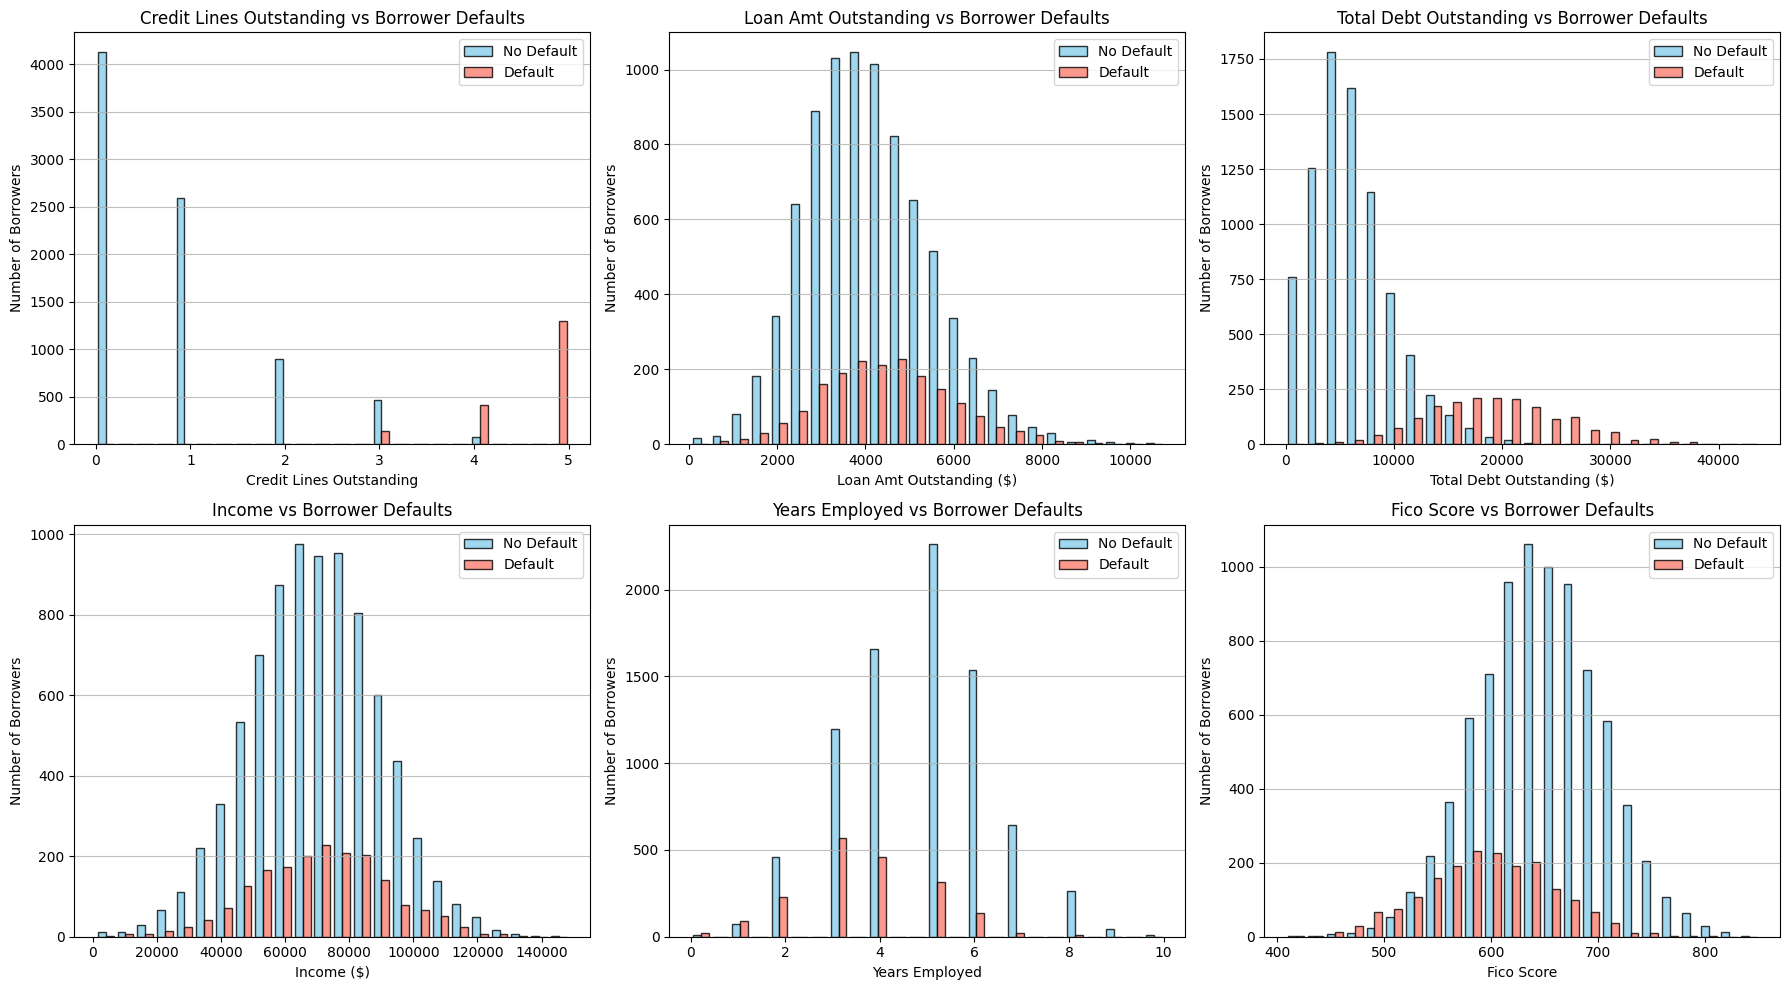

In [11]:
# Make 6 plots of each feature compared with default {0,1} to visualize correlation
features = [
    'credit_lines_outstanding',
    'loan_amt_outstanding',
    'total_debt_outstanding',
    'income',
    'years_employed',
    'fico_score'
]

# add dollar sign to xlabel if a money unit
features_dollar_sign = [
    'loan_amt_outstanding',
    'total_debt_outstanding',
    'income'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10)) # 2 rows 3 columns
axes = axes.flatten()

# Loop through each feature and create histograms
for idx, feature in enumerate(features):
    ax = axes[idx]

    no_defaults =  df[df['default'] == 0][feature]
    yes_defaults = df[df['default'] == 1][feature]

    bins = np.linspace(start=df[feature].min(), stop=df[feature].max(), num=25)

    # Plot histograms
    ax.hist(
        [no_defaults, yes_defaults],
        bins=bins,
        label=['No Default', 'Default'],
        color=['skyblue', 'salmon'],
        alpha=0.8,
        edgecolor='black',
        stacked=False
    )

    # Set titles and labels
    ax.set_title(f'{feature.replace("_", " ").title()} vs Borrower Defaults')
    if feature in features_dollar_sign:
        ax.set_xlabel(f'{feature.replace("_", " ").title()} ($)')
    else:
        ax.set_xlabel(feature.replace("_", " ").title())
    ax.set_ylabel('Number of Borrowers')

    ax.legend()
    ax.grid(axis='y', alpha=0.8)

# Remove any unused subplots (if features list has less than total subplots)
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### These charts confirm our analysis of the correlation matrix heatmap and aid feature selection.  
#### Besides the obvious, it appears as if higher loan amount and higher incomes increase default rate slightly. Higher income wouldn't intuitively increase default rate except those borrowers could be more likely to take out loans. Income and savings rate is not available in the data here but is not necessarily correlated. Higher income borrowers could be more risk-on given their ability to pay back capital quicker or draw on existing assets. Speculation - so let us see what the model reveals.

# Data Processing (Train, Val, Test)

In [12]:
# All features
features = [
    'credit_lines_outstanding',
    'loan_amt_outstanding',
    'total_debt_outstanding',
    'income',
    'years_employed',
    'fico_score'
]
target = 'default'

# binary target (default = 1, no default = 0)
X, y = df[features], df[target]

# 20% data allocated to test (don't use til absolute end)
X_train_80pct, X_test_20pct, y_train_80pct, y_test_20pct = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 25% of the 80% train data to model validation (20% overall data)
# 60% of data for model training
X_train_60pct, X_val_20pct, y_train_60pct, y_val_20pct = train_test_split(
    X_train_80pct, y_train_80pct, test_size=0.25, random_state=42
)

# Initialize MinMaxScaler for other features and FICO score separately
scaler_other_features = MinMaxScaler(feature_range=(0, 1))
scaler_fico = MinMaxScaler(feature_range=(0, 1))

# Fit the FICO scaler on the known FICO bounds
scaler_fico.fit(pd.DataFrame({'fico_score': [300, 850]}))

# Apply MinMax scaling to FICO score
X_train_60pct['fico_score'] = scaler_fico.transform(X_train_60pct[['fico_score']])
X_val_20pct['fico_score'] =   scaler_fico.transform(X_val_20pct[['fico_score']])
X_test_20pct['fico_score'] =  scaler_fico.transform(X_test_20pct[['fico_score']])

# Apply MinMax scaling to all other features except FICO score
features_to_scale = [col for col in X_train_60pct.columns if col != 'fico_score']

# Ensure scaler uses DataFrame and feature names
X_train_60pct[features_to_scale] = scaler_other_features.fit_transform(X_train_60pct[features_to_scale])
X_val_20pct[features_to_scale] =   scaler_other_features.transform(X_val_20pct[features_to_scale])
X_test_20pct[features_to_scale] =  scaler_other_features.transform(X_test_20pct[features_to_scale])

# Model Evaluation

## Basic Models - no Tuning

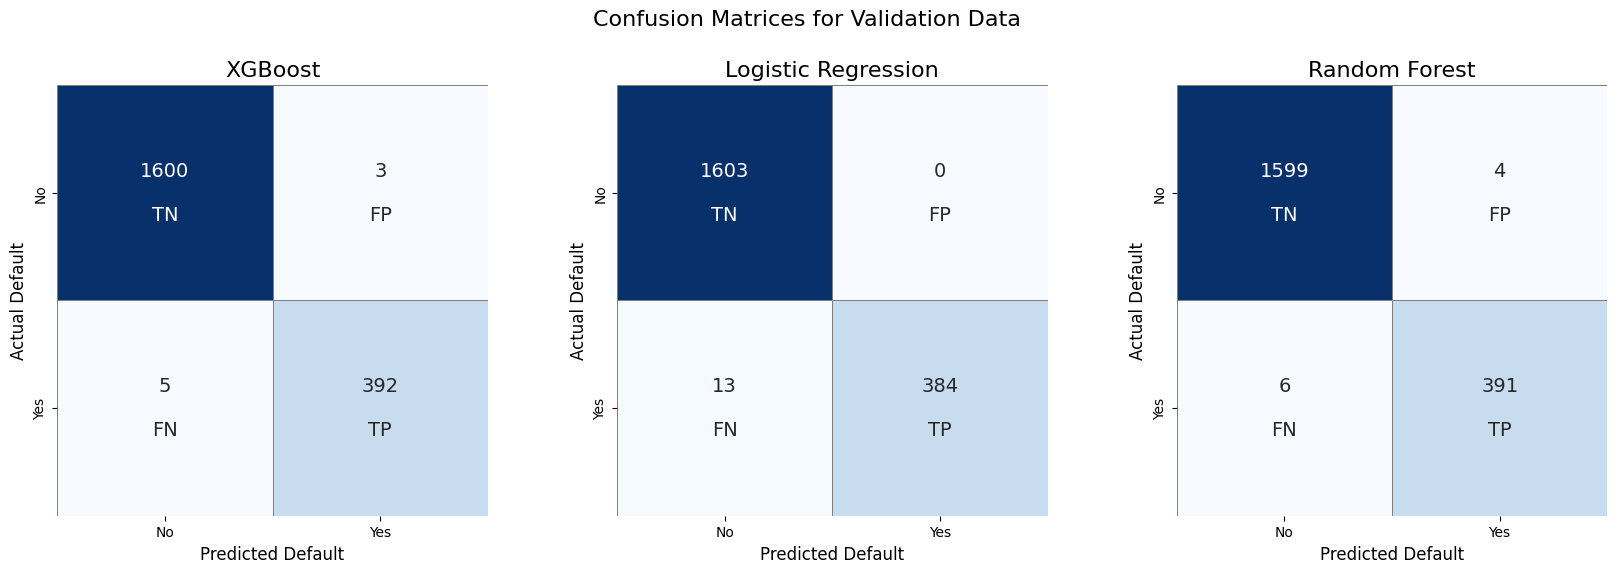

In [13]:
# basic xgb model
model_xgb = XGBClassifier()
model_xgb.fit(X_train_60pct, y_train_60pct)
y_pred_xgb = model_xgb.predict(X_val_20pct)

# basic logistic regression model
model_lr = LogisticRegression()
model_lr.fit(X_train_60pct, y_train_60pct)
y_pred_lr = model_lr.predict(X_val_20pct)

# basic random forest model
model_rf = RandomForestClassifier()
model_rf.fit(X_train_60pct, y_train_60pct)
y_pred_rf = model_rf.predict(X_val_20pct)

# Create confusion matrices
cm_xgb = confusion_matrix(y_val_20pct, y_pred_xgb)
cm_lr = confusion_matrix(y_val_20pct, y_pred_lr)
cm_rf = confusion_matrix(y_val_20pct, y_pred_rf)

# Plotting confusion matrices separately with TP, FP, FN, TN labels
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Confusion Matrices for Validation Data', fontsize=16)

# Function to plot confusion matrices with labels (TN, FP, FN, TP)
def plot_confusion_matrix_only_with_labels(cm, model_name, ax_cm, cmap):
    labels = ['No', 'Yes']
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    # Adding labels like TN, FP, FN, TP with a blank newline after the counts
    annot = np.array([[f"{cm[0, 0]}\n\nTN", f"{cm[0, 1]}\n\nFP"],
                      [f"{cm[1, 0]}\n\nFN", f"{cm[1, 1]}\n\nTP"]])
    sns.heatmap(
        df_cm,
        annot=annot,  # Display TN, FP, FN, TP with counts
        fmt='s',  # String format for annotations
        cmap=cmap,
        ax=ax_cm,
        cbar=False,
        xticklabels=labels,
        yticklabels=labels,
        annot_kws={"size": 14},  # Font size for readability
        square=True,
        linewidths=.5,
        linecolor='gray'
    )
    ax_cm.set_title(model_name, fontsize=16)
    ax_cm.set_xlabel('Predicted Default', fontsize=12)
    ax_cm.set_ylabel('Actual Default', fontsize=12)

# Plot confusion matrices with labels
plot_confusion_matrix_only_with_labels(cm_xgb, 'XGBoost', axs[0], 'Blues')
plot_confusion_matrix_only_with_labels(cm_lr, 'Logistic Regression', axs[1], 'Blues')
plot_confusion_matrix_only_with_labels(cm_rf, 'Random Forest', axs[2], 'Blues')

plt.subplots_adjust(wspace=0.3)
plt.show()

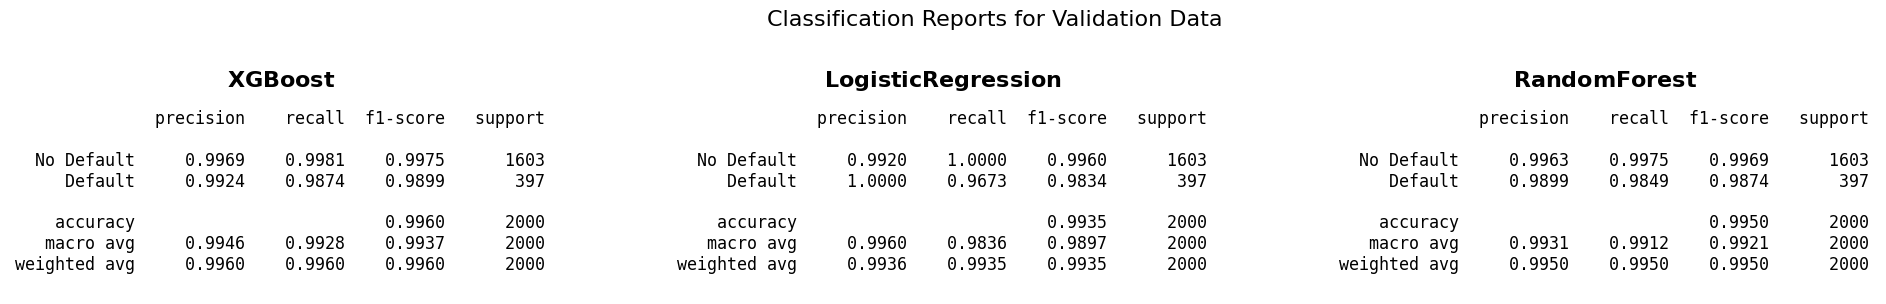

In [14]:
# Now, plot only the classification reports
fig, axs = plt.subplots(1, 3, figsize=(20, 3))
fig.suptitle('Classification Reports for Validation Data', fontsize=16)

# Create classification reports
report_xgb = classification_report(y_val_20pct, y_pred_xgb, target_names=['No Default', 'Default'], digits=4)
report_lr = classification_report(y_val_20pct, y_pred_lr, target_names=['No Default', 'Default'], digits=4)
report_rf = classification_report(y_val_20pct, y_pred_rf, target_names=['No Default', 'Default'], digits=4)

# Function to plot only classification reports
def plot_classification_report_only(report, model_name, ax_cr):
    ax_cr.axis('off')
    # Bold the model name and add space below it
    ax_cr.set_title(f'$\mathbf{{{model_name}}}$', fontsize=16, pad=10)  # Bold and add padding
    # Adjust the report display to add more space below the model name
    ax_cr.text(0.01, 0.95, report, fontsize=12, ha='left', va='top', family='monospace', transform=ax_cr.transAxes)

# Plot classification reports
plot_classification_report_only(report_xgb, 'XGBoost', axs[0])
plot_classification_report_only(report_lr, 'Logistic Regression', axs[1])
plot_classification_report_only(report_rf, 'Random Forest', axs[2])

# Adjust layout to remove all unnecessary space
plt.subplots_adjust(wspace=0.3, hspace=0.0)  # Reduce hspace to zero
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Manually adjust the bounding box to eliminate extra space at the bottom
plt.show()

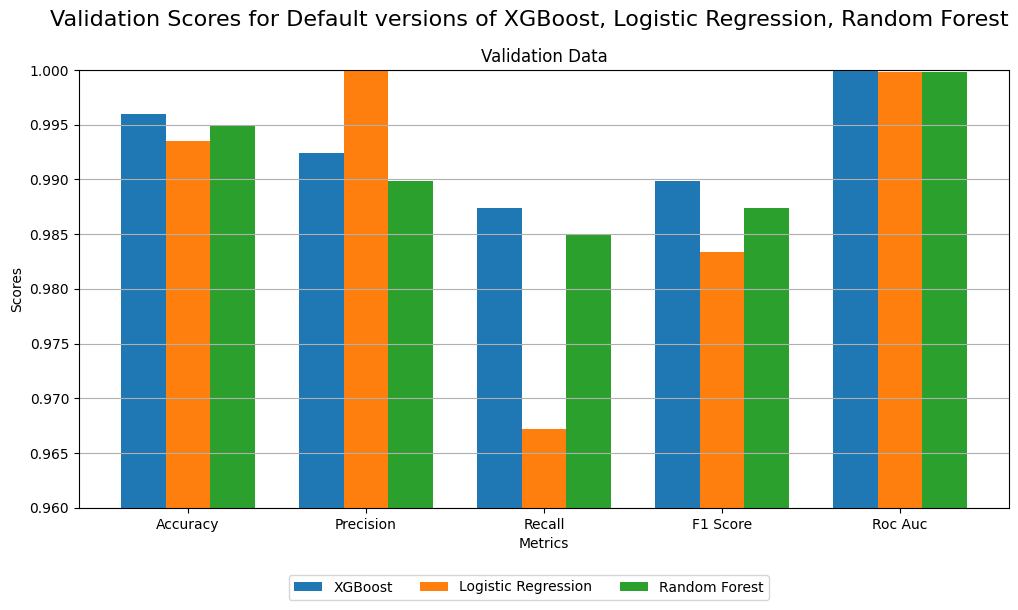

In [15]:
# Compute the validation scores for each model
val_scores = {
    'XGBoost': {
        'accuracy': accuracy_score(y_val_20pct, y_pred_xgb),
        'precision': precision_score(y_val_20pct, y_pred_xgb, zero_division='warn'),
        'recall': recall_score(y_val_20pct, y_pred_xgb, zero_division='warn'),
        'f1_score': f1_score(y_val_20pct, y_pred_xgb, zero_division='warn'),
        'roc_auc': roc_auc_score(y_val_20pct, model_xgb.predict_proba(X_val_20pct)[:, 1])
    },
    'Logistic Regression': {
        'accuracy': accuracy_score(y_val_20pct, y_pred_lr),
        'precision': precision_score(y_val_20pct, y_pred_lr, zero_division='warn'),
        'recall': recall_score(y_val_20pct, y_pred_lr, zero_division='warn'),
        'f1_score': f1_score(y_val_20pct, y_pred_lr, zero_division='warn'),
        'roc_auc': roc_auc_score(y_val_20pct, model_lr.predict_proba(X_val_20pct)[:, 1])
    },
    'Random Forest': {
        'accuracy': accuracy_score(y_val_20pct, y_pred_rf),
        'precision': precision_score(y_val_20pct, y_pred_rf, zero_division='warn'),
        'recall': recall_score(y_val_20pct, y_pred_rf, zero_division='warn'),
        'f1_score': f1_score(y_val_20pct, y_pred_rf, zero_division='warn'),
        'roc_auc': roc_auc_score(y_val_20pct, model_rf.predict_proba(X_val_20pct)[:, 1])
    }
}
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

# Create a bar chart for validation metrics
fig, ax_val = plt.subplots(figsize=(12, 6))
bar_width = 0.25
x = np.arange(len(metrics))

# Plotting the validation scores
for i, (model_name, model_scores) in enumerate(val_scores.items()):
    ax_val.bar(x + i * bar_width, [model_scores[m] for m in metrics], width=bar_width, label=model_name)

# Set chart labels and title for validation
ax_val.set_title('Validation Data')
ax_val.set_xlabel('Metrics')
ax_val.set_ylabel('Scores')
ax_val.set_xticks(x + bar_width)
ax_val.set_xticklabels([m.replace('_', ' ').title() for m in metrics])

# Adjust y-limits dynamically
y_bot = min(min(x.values()) for x in val_scores.values())
y_bot = math.floor(99.5 * y_bot) / 100
ax_val.set_ylim(y_bot, 1.0)
ax_val.grid(axis='y')

# Legend below plot, 1x3
handles, labels = ax_val.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)

fig.suptitle('Validation Scores for Default versions of XGBoost, Logistic Regression, Random Forest', fontsize=16)
plt.subplots_adjust(top=0.88, bottom=0.15, wspace=0.3)

plt.show()

#### Recall is the most imporant metric for loan default prediction, and out-of-the-box Logistic Regression is scoring poorly in that metric. XGBoost edges out Random Forest with no tuning, so we will explore XGBoost Classifier to see if we can boost Recall further.

## XGBoost Tuning

### Theshold Adjustment Seeking Highest Recall

In [16]:
# Get predicted probabilities for the positive class
y_pred_proba_xgb = model_xgb.predict_proba(X_val_20pct)[:, 1]

thresholds = np.arange(0.0, 1.0, 0.05)
actual_defaults = sum(y_val_20pct)  # Total actual defaults in the validation set

print(f"Actual num defaults in val data: {actual_defaults}\n")
print("Recall = TP / (TP + FN)\n")

for threshold in thresholds:
    y_pred_adjusted_xgb = (y_pred_proba_xgb >= threshold).astype(int)  # Adjust predictions based on threshold

    # Calculate true positives and false negatives
    TP = sum((y_val_20pct == 1) & (y_pred_adjusted_xgb == 1))
    FN = sum((y_val_20pct == 1) & (y_pred_adjusted_xgb == 0))

    recall_xgb = TP / (TP + FN)  # Calculate recall manually using TP / (TP + FN)

    # Calculate the number of predicted defaults
    predicted_defaults = sum(y_pred_adjusted_xgb)

    # Print the result with TP and FN breakdown
    print(f'Threshold {threshold:.2f}: Recall = {recall_xgb:.4f} = ({TP} / ({TP} + {FN}))')

Actual num defaults in val data: 397

Recall = TP / (TP + FN)

Threshold 0.00: Recall = 1.0000 = (397 / (397 + 0))
Threshold 0.05: Recall = 0.9975 = (396 / (396 + 1))
Threshold 0.10: Recall = 0.9924 = (394 / (394 + 3))
Threshold 0.15: Recall = 0.9924 = (394 / (394 + 3))
Threshold 0.20: Recall = 0.9924 = (394 / (394 + 3))
Threshold 0.25: Recall = 0.9924 = (394 / (394 + 3))
Threshold 0.30: Recall = 0.9899 = (393 / (393 + 4))
Threshold 0.35: Recall = 0.9874 = (392 / (392 + 5))
Threshold 0.40: Recall = 0.9874 = (392 / (392 + 5))
Threshold 0.45: Recall = 0.9874 = (392 / (392 + 5))
Threshold 0.50: Recall = 0.9874 = (392 / (392 + 5))
Threshold 0.55: Recall = 0.9874 = (392 / (392 + 5))
Threshold 0.60: Recall = 0.9849 = (391 / (391 + 6))
Threshold 0.65: Recall = 0.9849 = (391 / (391 + 6))
Threshold 0.70: Recall = 0.9849 = (391 / (391 + 6))
Threshold 0.75: Recall = 0.9849 = (391 / (391 + 6))
Threshold 0.80: Recall = 0.9849 = (391 / (391 + 6))
Threshold 0.85: Recall = 0.9824 = (390 / (390 + 7))
T

#### We don't use the always-0 threshold as that would correctly predict all defaults but classify all other borrowers as defaulters incorrectly and have horrible overall performance.
#### The 0.05 to 0.25 thresholds look promising with recall at 99.24%, but we will have to look at the False Positives and True Negatives to see at what cost the high recall comes at. Essentially, are we flagging too many borrowers and wasting the bank's time by requiring excessive manual review?
#### Thresholds from 0.35 to 0.55 have equivalent recall scores to our default threshold (0.50). This is an ok recall rate but we desire into the high 99.x%'s in order to predict almost every defaulting customer with minimal customers slipping through the cracks - defaulting when we predict they will not default.
#### I suspect that the threshold range of 0.15 to 0.25 will be best as we care about recall over all other metrics. I would rather err on the side of flase flagging borrowers so that a human can look at the data, rather than too many borrowers default and cost the bank money due to an inaccurate model for expected losses. If they don't allocate enough capital to cover losses, that is dangerous to other parts of the business. At the same time, they don't want idle money beyond what is necessary for covering risk as that cannot be used for investing in other areas.
#### Let us examine the feature values of the borrowers who were not flagged as default but should have been to see if our model is way off or they were unlikely defaulters given their profile.

In [17]:
# Reset index for X_val_20pct and y_val_20pct to ensure alignment
X_val_20pct_reset = X_val_20pct.reset_index(drop=True)
y_val_20pct_reset = y_val_20pct.reset_index(drop=True)

# Get predicted probabilities for the positive class
y_pred_proba_xgb = model_xgb.predict_proba(X_val_20pct_reset)[:, 1]

actual_defaults = sum(y_val_20pct_reset)  # Total actual defaults in the validation set

thresholds = [0.0, 0.10, 0.20, 0.25, 0.30, 0.50]
for threshold in thresholds:
    # recall score given current threshold
    y_pred_adjusted_xgb = (y_pred_proba_xgb >= threshold).astype(int)
    recall_xgb = recall_score(y_val_20pct_reset, y_pred_adjusted_xgb)

    # Find False Negatives: Actual defaults that were not predicted as defaults
    FN = X_val_20pct_reset[(y_val_20pct_reset == 1) & (y_pred_adjusted_xgb == 0)]
    false_negative_labels = y_val_20pct_reset[(y_val_20pct_reset == 1) & (y_pred_adjusted_xgb == 0)]

    # Find False Positives: Borrowers predicted as defaults but didn't default
    FP = X_val_20pct_reset[(y_val_20pct_reset == 0) & (y_pred_adjusted_xgb == 1)]
    false_positive_labels = y_val_20pct_reset[(y_val_20pct_reset == 0) & (y_pred_adjusted_xgb == 1)]

    predicted_defaults = sum(y_pred_adjusted_xgb)
    fn_count = sum((y_val_20pct_reset == 1) & (y_pred_adjusted_xgb == 0))
    tp_count = sum((y_val_20pct_reset == 1) & (y_pred_adjusted_xgb == 1))

    print(f'Threshold {threshold:.2f}: Recall = '
          f'({tp_count} / ({tp_count} + {fn_count})) = {recall_xgb:.4f}')

    # Set display options to prevent line wrapping (wide screen friendly)
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', None)

    # Print false negatives and positives with their features
    print(f'False Negatives (Actual Defaults but Not Predicted as Default): {FN.shape[0]}\n{FN}')
    print(f'False Positives (Predicted as Default but Did Not Default): {FP.shape[0]}\n{FP}')
    print("\n" + "="*120 + "\n")

Threshold 0.00: Recall = (397 / (397 + 0)) = 1.0000
False Negatives (Actual Defaults but Not Predicted as Default): 0
Empty DataFrame
Columns: [credit_lines_outstanding, loan_amt_outstanding, total_debt_outstanding, income, years_employed, fico_score]
Index: []
False Positives (Predicted as Default but Did Not Default): 1603
      credit_lines_outstanding  loan_amt_outstanding  total_debt_outstanding    income  years_employed  fico_score
2                          0.0              0.488229                0.104041  0.459389             0.4    0.743636
3                          0.2              0.425095                0.287614  0.568100             0.3    0.492727
4                          0.2              0.599792                0.227418  0.702938             0.6    0.689091
6                          0.2              0.318036                0.204137  0.437108             0.6    0.680000
7                          0.2              0.508146                0.224104  0.597396            

#### Although we correctly predict defaulting borrowers at the low thresholds, the number of False Positives is high (flagging non-defaulting borrowers), which is a tradeoff of the model.
#### The 0.20 and 0.25 thresholds are great with 3 incorrect predictions for both defaulting and not defaulting.
#### Then as we scale the thresholds higher, the 0.30 adds another False Negative - undetected default, and the 0.50 threshold adds 2 more.
#### I omitted printing 0.15 as it performs the same as the 0.10 threshold.

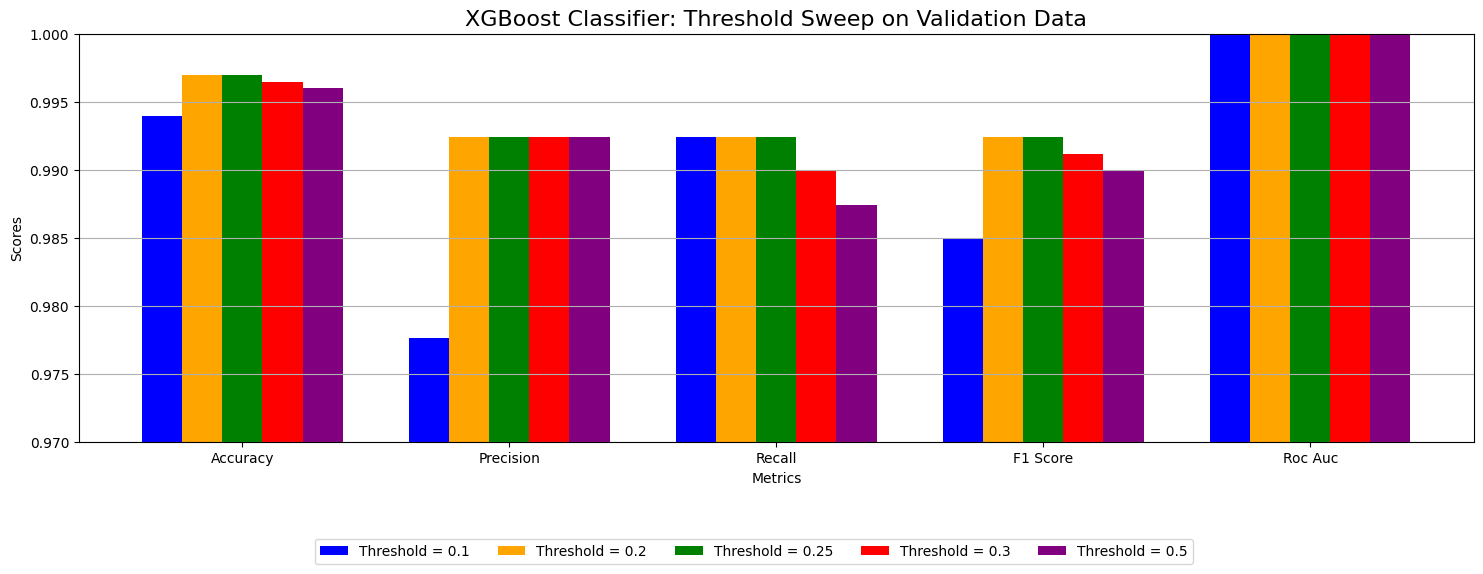

In [18]:
# Thresholds to evaluate, support up to 5
thresholds = [0.10, 0.20, 0.25, 0.30, 0.50]

# Train XGBoost model
model_xgb = XGBClassifier()
model_xgb.fit(X_train_60pct, y_train_60pct)

def get_val_metrics_for_threshold(threshold):
    # Predictions with the threshold for validation set
    y_pred_proba_val = model_xgb.predict_proba(X_val_20pct)[:, 1]
    y_pred_xgb_val = (y_pred_proba_val >= threshold).astype(int)

    # Compute metrics for validation set, 5 digits past decimal point
    val_scores = {
        'accuracy': round(accuracy_score(y_val_20pct, y_pred_xgb_val), 5),
        'precision': round(precision_score(y_val_20pct, y_pred_xgb_val, zero_division='warn'), 5),
        'recall': round(recall_score(y_val_20pct, y_pred_xgb_val, zero_division='warn'), 5),
        'f1_score': round(f1_score(y_val_20pct, y_pred_xgb_val, zero_division='warn'), 5),
        'roc_auc': round(roc_auc_score(y_val_20pct, model_xgb.predict_proba(X_val_20pct)[:, 1]), 5)
    }
    return val_scores

val_scores_dict = {threshold: get_val_metrics_for_threshold(threshold) for threshold in thresholds}

# Create a bar chart for validation metrics
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

fig, ax = plt.subplots(figsize=(18, 6))
bar_width = 0.2 - 0.05 * abs(4 - len(thresholds))
x = np.arange(len(metrics))

color_options = ['blue', 'orange', 'green', 'red', 'purple']
for idx, threshold in enumerate(thresholds):
    ax.bar(x + idx * bar_width, [val_scores_dict[threshold][m] for m in metrics],
           width=bar_width, label=f'Threshold = {threshold}', color=color_options[idx])

ax.set_title('XGBoost Classifier: Threshold Sweep on Validation Data', fontsize=16)
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_xticks(x + bar_width * (len(thresholds) - 1) / 2)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics])
ax.grid(axis='y')

# about a tick below the lowest score (y axis)
y_bot = min(min(x.values()) for x in val_scores_dict.values())
y_bot = math.floor(99.5 * y_bot) / 100
ax.set_ylim(y_bot, 1.0)

# Move legend below the plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
           bbox_to_anchor=(0.5, 0.05), ncol=len(thresholds))

plt.subplots_adjust(top=0.88, bottom=0.2)
plt.show()

#### Across all metrics, the **0.20 and 0.25 thresholds** are best or tied for best scoring in our XGBoost Classifier. Without hyperparameter tuning, this appears to give the peak performance when optimizing for recall.
#### Although the recall of the 0.10 threshold ties the 0.20/0.25 thresholds, all other metrics besides roc auc perform worse. There is decay in performance with the higher thresholds - 0.30 and onward - as well, but they were unlikely to be in contention due to the worse recall rates.

## XGBoost Hyperparameter Tuning

In [19]:
# for reference: XGBClassifier defaults
#
# class XGBClassifier(BaseXGBoostClassifier):
#     def __init__(self, *,
#                  objective='binary:logistic',
#                  use_label_encoder=False,
#                  base_score=0.5,
#                  booster='gbtree',
#                  n_estimators=100,
#                  max_depth=6,
#                  min_child_weight=1,
#                  gamma=0,
#                  learning_rate=0.3,  # alias: eta
#                  n_jobs=1,
#                  nthread=None,  # Deprecated, use `n_jobs`
#                  random_state=0,
#                  verbosity=1,
#                  silent=None,  # Deprecated, use `verbosity`
#                  tree_method='auto',
#                  gpu_id=-1,
#                  predictor='auto',
#                  eval_metric=None,
#                  early_stopping_rounds=None,
#                  num_parallel_tree=1,
#                  monotone_constraints=None,
#                  interaction_constraints=None,
#                  importance_type='gain',
#                  max_delta_step=0,
#                  subsample=1,
#                  colsample_bytree=1,
#                  colsample_bylevel=1,
#                  colsample_bynode=1,
#                  reg_alpha=0,
#                  reg_lambda=1,
#                  scale_pos_weight=1,
#                  base_margin=None,
#                  missing=np.nan,
#                  num_class=0,  # For multi-class classification
#                  max_bin=256,
#                  grow_policy='depthwise',
#                  validate_parameters=None,
#                  feature_weights=None,
#                  enable_categorical=False,
#                  feature_types=None,
#                  max_cat_to_onehot=4,
#                  max_cat_threshold=64,
#                  single_precision_histogram=False,
#                  **kwargs):

In [20]:
# notes taken from testing, not using this param dict anymore
param_grid_xgb_sweep = {
    'n_estimators': [600],  # default=100
    # 400 usually good too
    # , 600, 800, 1000], # most commonly 400-700 range
    'learning_rate': [0.01], # default=0.3
    # 0.01 every case top recall scores, 0.0, 0.02, 0.03], #, 0.05, 0.10],
    # didn't see many top results from >= 0.05
    'max_depth': [3, 4], # default=6
    # best is 4 then 5
    # 8, 10, 12, 14], # [3, 5, 7],
    'min_child_weight': [5], # default=1
    # seeing 5 almost always from a [1, 3, 5, 7, 9]
    # 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], #, 0.5], default=0
    'gamma': [0.0, 0.1], # default=0
    # 0.2, 0.5], low gamma best
    # higher gamma for deeper trees
    # saw top recall results from each ^ gammma above
    'reg_alpha': [0.01], # default=0
    # 0.01 does the best
    #, 0.0, 0.1, 0.3, 0.5, 0.7, 0.9],  # L1 regularization
    'reg_lambda': [0.3], # default=1
     # [0.3, 0.6, 1, 2], 0.3 best
    # 0.1 not hit, 3 not hit
    #, 0.5, 0.7, 0.9], # L2 regularization
    'scale_pos_weight': [15, 20], # default=1
    #, 15, 20],
    #, 25, 30], # 20 gets strong results
    # <=10 or >=35 not top;  BIG RECALL BOOST {15, 20}
    # 'num_parallel_tree': [1, 2, 4, 16], # default=1
    # 16 caused it to be super slow
    # 'booster': ['gbtree', 'dart'], default='gbtree'
    # dart takes very long, does dropout
    # 'base_score': [0.5], # default=0.5
    # best at 0.5
    # 0.2, 0.3, 0.5],
    # \/ these colsample_by{level,node} overfit the data
    # 'colsample_bylevel': [0.9],  # Fraction of features used at each level
    # 'colsample_bynode': [0.9],  # Fraction of features used at each node
    'tree_method': ['hist'],
    'device': ['cuda'] # since 'gpu_hist' deprecated
    # !nvidia-smi
    # if no GPU then can do slow, accurate exact w/CPU
    # 'tree_method': ['exact'], 'device': ['cpu']
}

## Use Grid Search on parameters to Optimize XGBoost Classifier Performance

In [21]:
# After many runs of grid search (notes above), these seem to be optimal params
param_grid_xgb = {
    'tree_method': ['hist'], # efficient for gpu
    'device': ['cuda'], # since 'gpu_hist' deprecated

    'n_estimators': [600],  # default=100
    'learning_rate': [0.01], # default=0.3
    'max_depth': [4, 6], # default=6
    'min_child_weight': [1, 5], # default=1
    'reg_alpha': [0.01], # default=0
    'reg_lambda': [0.3], # default=1
    'scale_pos_weight': [20], # default=1

    'subsample': [0.9], # default=1
    'colsample_bytree': [0.9], # default=1
}

def calc_custom_score_with_threshold(model, X_val, y_val, threshold=0.5):
    """
    I created this function to give highest priority to recall, but make
    precision also have decent importance, followed by other metrics.
    A high-99% recall score with 97% precision is more usable than a
    100% recall score with 90% precision, for example.
    And a precision score below our default models (98%) is not worth considering

    """
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division='warn')
    recall = recall_score(y_val, y_pred, zero_division='warn')
    f1 = f1_score(y_val, y_pred, zero_division='warn')
    roc_auc = roc_auc_score(y_val, y_pred_proba)
    custom_score = (
        0.1 * accuracy +
        0.3 * precision +
        0.5 * recall +  # Emphasizing recall
        0.05 * f1 +
        0.05 * roc_auc
    )
    return custom_score

# Wrapper function to pass threshold explicitly
def custom_scorer_with_threshold(y_true, y_pred_proba, model=None, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    return calc_custom_score_with_threshold(
        model, X_val=None, y_val=y_true, threshold=threshold
    )

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division='warn', greater_is_better=True),
    'recall': make_scorer(recall_score, zero_division='warn', greater_is_better=True),
    'f1': make_scorer(f1_score, zero_division='warn', greater_is_better=True),
    'roc_auc': 'roc_auc',
    'custom_score': make_scorer(custom_scorer_with_threshold, greater_is_better=True)
}

# XGBoost grid search object
num_kfold_splits = 5
grid_search_xgb = GridSearchCV(
    XGBClassifier(),
    param_grid_xgb,
    scoring=scoring,
    refit='recall',
    # refit='custom_score',
    # refit='precision',
    cv=num_kfold_splits,
    verbose=2,
    n_jobs=-1
)

# fit the model to the training data
grid_search_xgb.fit(X_train_60pct, y_train_60pct)

# did random=42 split for train val test, so don't have to shuffle folds here
kf = KFold(n_splits = num_kfold_splits)
thresholds = [0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80]
results_xgb_grid_search = []
for _, params in enumerate(grid_search_xgb.cv_results_['params']):
    print(f"Evaluating params: {params}")

    # Initialize lists to store metrics for each threshold
    metrics_per_threshold = {
        threshold: {
            'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [], 'custom_score': []
        } for threshold in thresholds
    }

    # Loop through KFold cross-validation
    for train_idx, val_idx in kf.split(X_train_60pct):
        X_train_fold, X_val_fold = X_train_60pct.iloc[train_idx], X_train_60pct.iloc[val_idx]
        y_train_fold, y_val_fold = y_train_60pct.iloc[train_idx], y_train_60pct.iloc[val_idx]

        # initialize model, fit on training fold
        xgb_model = XGBClassifier(**params)
        xgb_model.fit(X_train_fold, y_train_fold)

        # Predict probabilities on the val fold
        y_pred_proba_val = xgb_model.predict_proba(X_val_fold)[:, 1]

        # Loop through each threshold and calculate metrics
        for threshold in thresholds:
            y_pred_val = (y_pred_proba_val >= threshold).astype(int)

            # Calculate metrics for this fold and threshold
            metrics_per_threshold[threshold]['accuracy'].append(accuracy_score(y_val_fold, y_pred_val))
            metrics_per_threshold[threshold]['precision'].append(precision_score(y_val_fold, y_pred_val, zero_division='warn'))
            metrics_per_threshold[threshold]['recall'].append(recall_score(y_val_fold, y_pred_val, zero_division='warn'))
            metrics_per_threshold[threshold]['f1'].append(f1_score(y_val_fold, y_pred_val, zero_division='warn'))
            metrics_per_threshold[threshold]['roc_auc'].append(roc_auc_score(y_val_fold, y_pred_proba_val))
            metrics_per_threshold[threshold]['custom_score'].append(
                calc_custom_score_with_threshold(xgb_model, X_val_fold, y_val_fold, threshold)
            )

    # for each threshold, save the average of each metric from k folds
    # if valid and considered competitive enough
    for threshold in thresholds:

        # Calculate the average metrics
        accuracy = np.nanmean(metrics_per_threshold[threshold]['accuracy'])
        precision = np.nanmean(metrics_per_threshold[threshold]['precision'])
        recall = np.nanmean(metrics_per_threshold[threshold]['recall'])
        f1 = np.nanmean(metrics_per_threshold[threshold]['f1'])
        roc_auc = np.nanmean(metrics_per_threshold[threshold]['roc_auc'])
        custom_score = np.nanmean(metrics_per_threshold[threshold]['custom_score'])

        """
        Store the results if recall score, all scores are competitive
        for close to 1.00 recall scores, other metrics tend to decrease
        """
        min_recall_score, min_any_score = 0.990, 0.960
        if recall < min_recall_score or min([ float(score) for score in \
            [accuracy, precision, recall, f1, roc_auc] ]) < min_any_score: continue

        results_xgb_grid_search.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'custom_score': custom_score,
            'threshold': threshold,
            'params': params
        })

df_results_gs_xgb = pd.DataFrame(results_xgb_grid_search)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Evaluating params: {'colsample_bytree': 0.9, 'device': 'cuda', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 600, 'reg_alpha': 0.01, 'reg_lambda': 0.3, 'scale_pos_weight': 20, 'subsample': 0.9, 'tree_method': 'hist'}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [00:08:36] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Evaluating params: {'colsample_bytree': 0.9, 'device': 'cuda', 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 600, 'reg_alpha': 0.01, 'reg_lambda': 0.3, 'scale_pos_weight': 20, 'subsample': 0.9, 'tree_method': 'hist'}
Evaluating params: {'colsample_bytree': 0.9, 'device': 'cuda', 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 600, 'reg_alpha': 0.01, 'reg_lambda': 0.3, 'scale_pos_weight': 20, 'subsample': 0.9, 'tree_method': 'hist'}
Evaluating params: {'colsample_bytree': 0.9, 'device': 'cuda', 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 600, 'reg_alpha': 0.01, 'reg_lambda': 0.3, 'scale_pos_weight': 20, 'subsample': 0.9, 'tree_method': 'hist'}


In [22]:
# 5 digits past decimal
df_results_gs_xgb = df_results_gs_xgb.round(decimals=5)

df_custom_score_sorted = df_results_gs_xgb.sort_values(
    by=['custom_score', 'recall', 'precision', 'accuracy', 'f1', 'roc_auc', 'threshold'],
    ascending=[False, False, False, False, False, False, True]
)
top_custom_score = df_custom_score_sorted.iloc[0]['custom_score']
top_custom_score_count = df_custom_score_sorted[df_custom_score_sorted['custom_score'] == top_custom_score].shape[0]

num_results = 10
if top_custom_score_count > num_results:
    print(f"Caution: look at full data since there is a {top_custom_score_count}-way tie for top custom score")
print(f"This is a weighted ranking prioritizing recall, then precision, then other metrics")
print(f"\nTop {num_results} results sorted by custom score:\n")
print(df_custom_score_sorted.head(num_results))

filename_custom_score = 'xgb_grid_search_sorted_by_custom_score.csv'
df_custom_score_sorted.to_csv(filename_custom_score, index=False)
print(f"\ncustom score sorted csv file: '{filename_custom_score}'")

This is a weighted ranking prioritizing recall, then precision, then other metrics

Top 10 results sorted by custom score:

    accuracy  precision   recall       f1  roc_auc  custom_score  threshold                                             params
3    0.99600    0.98565  0.99281  0.98918  0.99982       0.99115        0.8  {'colsample_bytree': 0.9, 'device': 'cuda', 'l...
10   0.99617    0.98827  0.99097  0.98959  0.99983       0.99105        0.7  {'colsample_bytree': 0.9, 'device': 'cuda', 'l...
9    0.99583    0.98648  0.99097  0.98868  0.99983       0.99044        0.6  {'colsample_bytree': 0.9, 'device': 'cuda', 'l...
8    0.99550    0.98297  0.99276  0.98782  0.99983       0.99021        0.5  {'colsample_bytree': 0.9, 'device': 'cuda', 'l...
7    0.99500    0.97950  0.99368  0.98651  0.99983       0.98951        0.4  {'colsample_bytree': 0.9, 'device': 'cuda', 'l...
2    0.99483    0.97868  0.99370  0.98609  0.99982       0.98923        0.7  {'colsample_bytree': 0.9, 'device': '

#### For our top performing custom-weighted XGBoost model, the recall score is definitely above a non-tuned model; however, I was seeking above 99.5%, so we will see how the Recall optimized model does next.

In [23]:
# top priority sort by recall, then lesser metrics
df_recall_score_sorted = df_results_gs_xgb.sort_values(
    by=['recall', 'precision', 'custom_score', 'accuracy', 'f1', 'roc_auc', 'threshold'],
    ascending=[False, False, False, False, False, False, True]
)
highest_recall_score = df_recall_score_sorted.iloc[0]['recall']
recall_top_score_count = df_recall_score_sorted[df_recall_score_sorted['recall'] == highest_recall_score].shape[0]

num_results = 10
print(f"\nTop {num_results} results sorted by recall:\n")
print(df_recall_score_sorted.head(num_results))

filename_recall = 'xgb_grid_search_sorted_by_recall.csv'
df_recall_score_sorted.to_csv('xgb_grid_search_sorted_by_recall.csv', index=False)

if recall_top_score_count > num_results:
    print(f"\nCaution: look at full data since there is a {recall_top_score_count}-way tie for top recall score")
print(f"\nrecall sorted csv file: '{filename_recall}'")

# print optimal threshold and params for highest recall score
print(f"\nOptimal threshold: {df_recall_score_sorted.iloc[0]['threshold']}")
print(f"Optimal explicit params: {df_recall_score_sorted.iloc[0]['params']}")


Top 10 results sorted by recall:

    accuracy  precision   recall       f1  roc_auc  custom_score  threshold                                             params
1    0.99367    0.97005  0.99639  0.98304  0.99982       0.98772        0.6  {'colsample_bytree': 0.9, 'device': 'cuda', 'l...
0    0.99250    0.96412  0.99639  0.97998  0.99982       0.98567        0.5  {'colsample_bytree': 0.9, 'device': 'cuda', 'l...
4    0.99283    0.96654  0.99550  0.98077  0.99980       0.98602        0.7  {'colsample_bytree': 0.9, 'device': 'cuda', 'l...
5    0.99450    0.97605  0.99460  0.98523  0.99980       0.98881        0.8  {'colsample_bytree': 0.9, 'device': 'cuda', 'l...
13   0.99383    0.97256  0.99460  0.98343  0.99981       0.98761        0.7  {'colsample_bytree': 0.9, 'device': 'cuda', 'l...
6    0.99333    0.97002  0.99460  0.98214  0.99983       0.98674        0.3  {'colsample_bytree': 0.9, 'device': 'cuda', 'l...
12   0.99233    0.96484  0.99460  0.97946  0.99981       0.98495        0.6 

#### Ok, we are done with the hyperparameter tuning.
#### We have a balanced model (2 code cells above) that weights importance on the metric scoring for the training and validation data, and a Recall - optimized model (just above) for our exact purpose of predicting borrowers defaulting.
#### Ultimately, our parameter boosting gave recall rates as high as 99.64%, which cannot get much better, and is a success compared to the 98% recall rate we saw on the default XGBoost Classifier model at the beginning of model evaluation.
#### I have tried many parameter options in various grid searches and XGBoost Classifier appears to be at its limits for top recall score, followed by precision, then other metrics. The precision at 97.01% was not amazing, but for the task at hand, we can make that tradeoff and tell the bank to look into the few profiles that are flagged but don't have a glaring reason to be.
#### The upside is that almost no borrowers are expected to default and surprise the bank since this recall is so high.

## Final Evaluation on the Test Data

### Showing the balanced model here for reference against the test data.

In [24]:
# Extract the top parameters from the DataFrame
top_params_balanced = df_custom_score_sorted.iloc[0]['params'] # Overall

# Ensure the parameters are in the correct format (dict)
if not isinstance(top_params_balanced, dict):
    if isinstance(top_params_balanced, pd.Series):
        top_params_balanced = top_params_balanced.to_dict()
    else:
        raise ValueError("Top parameters are not in the correct format.")

# Create and train the model using the top parameters
best_xgb_model_balanced = XGBClassifier(**top_params_balanced)
best_xgb_model_balanced.fit(X_train_60pct, y_train_60pct)

# Make predictions on the test data
y_test_pred_proba = best_xgb_model_balanced.predict_proba(X_test_20pct)[:, 1]
threshold = df_recall_score_sorted.iloc[0]['threshold'] # Recall
threshold = df_custom_score_sorted.iloc[0]['threshold'] # Overall
y_test_pred = (y_test_pred_proba >= threshold).astype(int)

# Compute evaluation metrics
accuracy_test = accuracy_score(y_test_20pct, y_test_pred)
precision_test = precision_score(y_test_20pct, y_test_pred, zero_division='warn')
recall_test = recall_score(y_test_20pct, y_test_pred, zero_division='warn')
f1_test = f1_score(y_test_20pct, y_test_pred, zero_division='warn')
roc_auc_test = roc_auc_score(y_test_20pct, y_test_pred_proba)

print("Evaluation Metrics on Test Data using Top Parameters and Custom Score:")
print(f"Accuracy: {accuracy_test:.5f}")
print(f"Precision: {precision_test:.5f}")
print(f"Recall: {recall_test:.5f}")
print(f"F1 Score: {f1_test:.5f}")
print(f"ROC AUC: {roc_auc_test:.5f}")
print(f"Threshold: {threshold}")

# Save the model
joblib.dump(best_xgb_model_balanced, 'best_xgb_model_balanced.pkl')

Evaluation Metrics on Test Data using Top Parameters and Custom Score:
Accuracy: 0.99500
Precision: 0.98563
Recall: 0.98563
F1 Score: 0.98563
ROC AUC: 0.99980
Threshold: 0.8


['best_xgb_model_balanced.pkl']

#### Our recall does not perform well here, and that is fine as we want the recall-optimized model.


### Showing the recall-optimized model performance with the test data

In [25]:
# Extract the top parameters from the DataFrame sorted by recall
top_params_recall = df_recall_score_sorted.iloc[0]['params'] # Recall

# Ensure the parameters are in the correct format (dict)
if not isinstance(top_params_recall, dict):
    if isinstance(top_params_recall, pd.Series):
        top_params_recall = top_params_recall.to_dict()
    else:
        raise ValueError("Top parameters are not in the correct format.")

# Create and train the model using the top parameters
best_xgb_model_recall = XGBClassifier(**top_params_recall)
best_xgb_model_recall.fit(X_train_60pct, y_train_60pct)

# Make predictions on the test data
y_test_pred_proba = best_xgb_model_recall.predict_proba(X_test_20pct)[:, 1]
threshold = df_recall_score_sorted.iloc[0]['threshold'] # Recall
y_test_pred = (y_test_pred_proba >= threshold).astype(int)

# Compute evaluation metrics
accuracy_test = accuracy_score(y_test_20pct, y_test_pred)
precision_test = precision_score(y_test_20pct, y_test_pred, zero_division='warn')
recall_test = recall_score(y_test_20pct, y_test_pred, zero_division='warn')
f1_test = f1_score(y_test_20pct, y_test_pred, zero_division='warn')
roc_auc_test = roc_auc_score(y_test_20pct, y_test_pred_proba)

# Display the evaluation metrics
print("Evaluation Metrics on Test Data using Top Parameters:")
print(f"Accuracy: {accuracy_test:.5f}")
print(f"Precision: {precision_test:.5f}")
print(f"Recall: {recall_test:.5f}")
print(f"F1 Score: {f1_test:.5f}")
print(f"ROC AUC: {roc_auc_test:.5f}")
print(f"Threshold: {threshold}")

# Optionally, save the model if needed
joblib.dump(best_xgb_model_recall, 'best_xgb_model_recall.pkl')

Evaluation Metrics on Test Data using Top Parameters:
Accuracy: 0.99600
Precision: 0.98295
Recall: 0.99425
F1 Score: 0.98857
ROC AUC: 0.99980
Threshold: 0.6


['best_xgb_model_recall.pkl']

#### Our Recall model does a bit less than our results on the validation data in the recall metric, but not far off. Recall appears to result in typical scores of 99.5% give or take.
#### Precision here is a pleasant surprise as it gets into respectable territory at roughly 98.3% and is an overall good model now, not just at recall.
#### I would call this a success for the XGBoost Classifier and for predicting borrower defaults.
#### We can evaluate other models and tune those as well, but the performance won't get much better than this one.

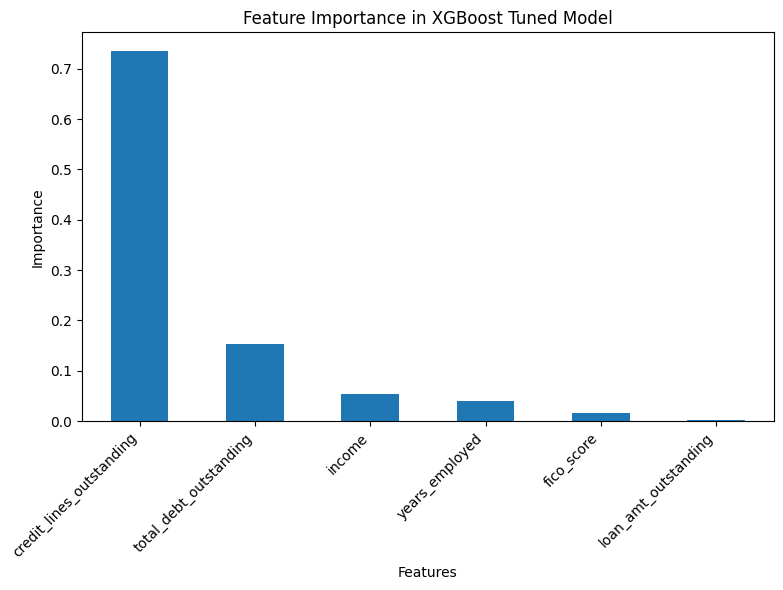

In [26]:
# Feature importance of model
coefficients = pd.Series(best_xgb_model_recall.feature_importances_, index=X_train_60pct.columns)
coefficients.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(8, 6))  # Adjusted the figure size for better clarity
coefficients.plot(kind='bar')
plt.title('Feature Importance in XGBoost Tuned Model')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#### The prediction of a default largely comes down to how many credit lines a borrower has. There is very little relation to income, years employed, fico score, and loan amount outstanding. I would have expected fico score to have a >= 20% impact as it is a model made up of how well people borrow money and pay others back. Total debt outstanding has around a 15% impact as a distant second predictor of default.

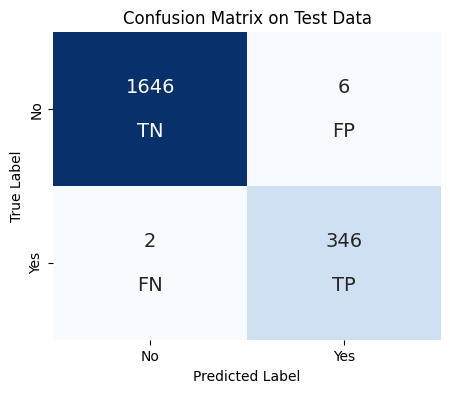

In [27]:
conf_matrix = confusion_matrix(y_test_20pct, y_test_pred)

labels = np.array([
    [f"{conf_matrix[0, 0]}\n\nTN", f"{conf_matrix[0, 1]}\n\nFP"],
    [f"{conf_matrix[1, 0]}\n\nFN", f"{conf_matrix[1, 1]}\n\nTP"]
])
tick_labels = ['No Default', 'Default']

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 14})

plt.title('Confusion Matrix on Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['No', 'Yes'])
plt.yticks([0.5, 1.5], ['No', 'Yes'])
plt.show()

#### Although I used a random=42 seed for train (val) test split, there are around 50 fewer defaults in the test data (\~350) that in the validation data (\~400), which was unexpected. The lower count makes each miss more noticeable, for example, we only let 2 borrowers default without predicting, but that goes down to 99.4% recall.
#### The 6 False Positives is not fairly good, and the True Positives and False Negatives really shine in this model, which is a mission accomplished.

# Expected Loss

In [28]:
def calc_expected_loss(PD: pd.Series, loan_amount: pd.Series, RECOVERY_RATE=0.10) -> pd.Series:
    """
    PD: pd.Series, probability of default 0.0 <= PD <= 1.0
    loan_amount: pd.Series, loan amount ($)
    RECOVERY_RATE: float, assume 10% recovery rate

    returns: pd.Series, expected loss on loan ($)
    """
    if PD.min() < 0.0 or PD.max() > 1.0:
        print("Error, probability of default does not compute\n{PD = }\n")
        return PD

    expected_loss = loan_amount * PD * (1.00 - RECOVERY_RATE)
    # print(f"Expected loss on loan: ${expected_loan_loss:.2f}")
    return expected_loss

In [29]:
id_min = df['customer_id'].max() + 1
num_customers = 2000

def generate_random_customers(id_min, num_customers) -> pd.DataFrame:

    df_customers = pd.DataFrame({
        'customer_id': [ id_min+x for x in range(1, num_customers+1) ],
        'credit_lines_outstanding': [ random.Random().randint(0, 5) for _ in range(num_customers) ],
        'loan_amt_outstanding': [ random.Random().randint(0, 10000) for _ in range(num_customers) ],
        'total_debt_outstanding': [ random.Random().randint(0, 100000) for _ in range(num_customers) ],
        'income': [ random.Random().randint(0, 100000) for _ in range(num_customers) ],
        'years_employed': [ random.Random().randint(0, 10) for _ in range(num_customers) ],
        'fico_score': [ random.Random().randint(300, 850) for _ in range(num_customers) ],
        'default': [ None for _ in range(num_customers) ]
    })
    return df_customers


df_borrowers = generate_random_customers(id_min, num_customers)

X_borrowers, y_borrowers = df_borrowers.drop(columns=['customer_id', 'default']), df_borrowers['default']

# Fit the FICO scaler on the known FICO bounds
scaler_fico = MinMaxScaler(feature_range=(0, 1))
scaler_fico.fit(pd.DataFrame({'fico_score': [300, 850]}))
X_borrowers['fico_score'] = scaler_fico.transform(X_borrowers[['fico_score']])

features_to_scale = [col for col in X_borrowers.columns if col != 'fico_score']
scaler_other_features = MinMaxScaler(feature_range=(0, 1))
X_borrowers[features_to_scale] = scaler_other_features.fit_transform(X_borrowers[features_to_scale])

def predict_default_proba(model, df_in: pd.DataFrame) -> pd.Series:
    default_probs = model.predict_proba(X_borrowers)[:, 1]
    return pd.Series(default_probs, index=df_in.index)

df_borrowers['default_likelihood'] = predict_default_proba(
    model=best_xgb_model_recall, df_in=X_borrowers
)

threshold = df_recall_score_sorted.iloc[0]['threshold'] # Recall
print(f"Using threshold of {threshold} and recall-optimized model")
df_borrowers['default'] = (
    df_borrowers['default_likelihood'] >= threshold).astype(int)

df_borrowers['expected_loss'] = calc_expected_loss(
    df_borrowers['default_likelihood'], df_borrowers['loan_amt_outstanding']
)

# make a column to add the percentage of expected loss
df_borrowers['expected_loss_pct'] = 100 * df_borrowers['expected_loss'] \
    / df_borrowers['loan_amt_outstanding']

df_borrowers

Using threshold of 0.6 and recall-optimized model


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,default_likelihood,expected_loss,expected_loss_pct
0,8999791,0,8842,95303,26632,2,697,0,0.075411,600.104228,6.786974
1,8999792,0,5397,8504,6921,0,315,0,0.196793,955.882228,17.711362
2,8999793,0,7567,56489,71050,0,555,0,0.270966,1845.360111,24.386945
3,8999794,4,8957,14935,29168,9,732,0,0.004558,36.742150,0.410206
4,8999795,4,3601,75877,91986,5,324,1,0.998464,3235.923485,89.861802
...,...,...,...,...,...,...,...,...,...,...,...
1995,9001786,4,7845,92803,8322,3,344,1,0.999016,7053.553638,89.911455
1996,9001787,0,8397,78309,32261,1,329,0,0.528726,3995.739510,47.585322
1997,9001788,2,2048,91392,18067,9,446,0,0.103962,191.622354,9.356560
1998,9001789,2,6779,64073,27066,9,437,0,0.106246,648.219892,9.562176


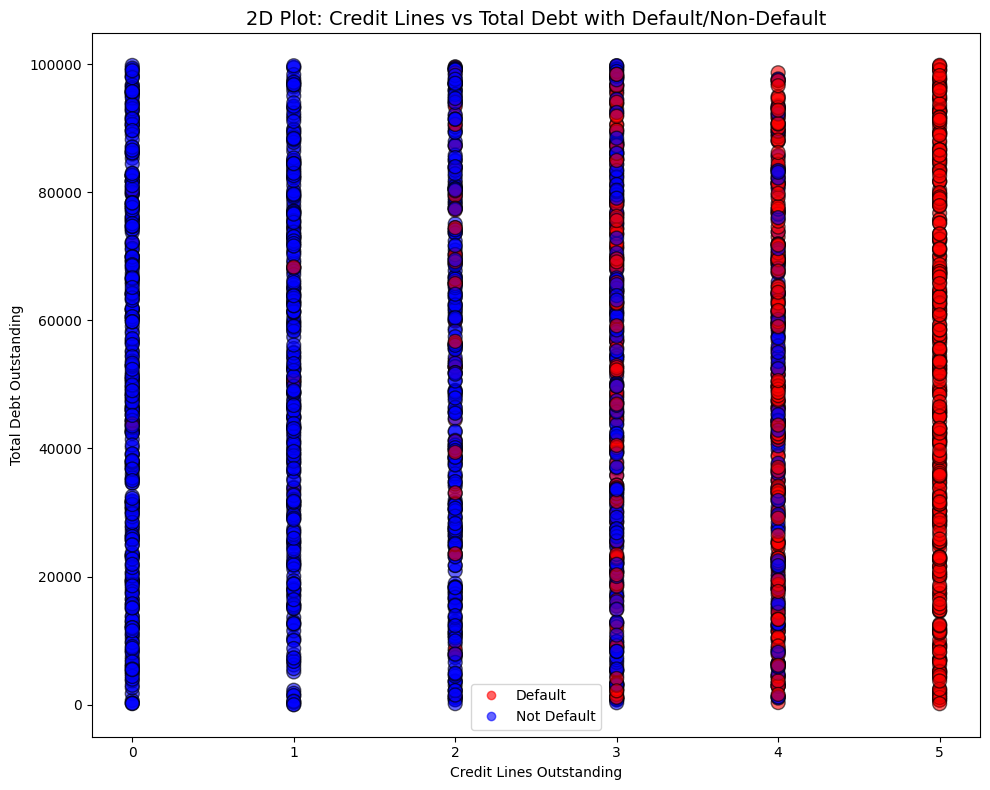

In [30]:
# 2D scatter plot: Credit Lines vs Total Debt with Default/Non-Default coloring
plt.figure(figsize=(10, 8))

# Color map for default status
colors = df_borrowers['default'].map({1: 'red', 0: 'blue'})

plt.scatter(
    df_borrowers['credit_lines_outstanding'],
    df_borrowers['total_debt_outstanding'],
    c=colors,
    s=100,  # Marker size
    alpha=0.6,  # Transparency
    edgecolor='k'  # Black edges for markers
)

plt.title("2D Plot: Credit Lines vs Total Debt with Default/Non-Default", fontsize=14)
plt.xlabel("Credit Lines Outstanding")
plt.ylabel("Total Debt Outstanding")

# Create a legend for default/non-default
default_proxy = plt.Line2D([0], [0], linestyle="none", marker='o', color='red', label='Default', alpha=0.6)
not_default_proxy = plt.Line2D([0], [0], linestyle="none", marker='o', color='blue', label='Not Default', alpha=0.6)
plt.legend([default_proxy, not_default_proxy], ['Default', 'Not Default'], numpoints=1)

plt.tight_layout()
plt.show()

#### Interesting to see that credit lines alone is primarly responsible for default, as our model feature importance showed. The only cases where debt tended to have a bigger say than credit line was at 2 credit lines outstanding, where debt appears to be a higher predictor of default. At both extremes, credit line predicts default the majority of the time.